In [3]:
synthetic_timegan = np.load('../data/processed/synthetic_timegan.npy')
synthetic_vae = np.load('../data/processed/simulated_vae.npy')

## Load Real and Synthetic Data for Use Cases

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# real data
real_data = pd.read_csv('../data/raw/sp500.csv', index_col='Date', parse_dates=True)
real_data = real_data.apply(pd.to_numeric, errors='coerce')
close_prices = real_data['Close']
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
log_returns_array = log_returns.values.reshape(-1, 1)

# Normalize real log returns
scaler = MinMaxScaler()
log_returns_scaled = scaler.fit_transform(log_returns_array)

# Prepare real data (take the first 2400 log returns to match synthetic samples)
real_data_prepared = log_returns_array[:2400]

# Reload synthetic TimeGAN data
synthetic_timegan = np.load('../data/processed/synthetic_timegan.npy')

# Reload synthetic Simulated VAE data
synthetic_vae = np.load('../data/processed/simulated_vae.npy')

# Settings
sequence_length = 24  # 24 trading days ~ 1 month

# Reshape all datasets into sequences (n_sequences, sequence_length)
real_data_seq = real_data_prepared.reshape(-1, sequence_length)
synthetic_timegan_seq = synthetic_timegan.reshape(-1, sequence_length)
synthetic_vae_seq = synthetic_vae.reshape(-1, sequence_length)

print(f"Real Data sequences shape: {real_data_seq.shape}")
print(f"TimeGAN Synthetic sequences shape: {synthetic_timegan_seq.shape}")
print(f"Simulated VAE Synthetic sequences shape: {synthetic_vae_seq.shape}")

Real Data sequences shape: (100, 24)
TimeGAN Synthetic sequences shape: (100, 24)
Simulated VAE Synthetic sequences shape: (100, 24)


### Use Case 1 : Portfolio Optimization

In [5]:
from scipy.optimize import minimize

# Helper function: Portfolio metrics
def portfolio_performance(weights, returns):
    portfolio_return = np.sum(np.mean(returns, axis=0) * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(np.cov(returns.T), weights)))
    return portfolio_return, portfolio_volatility

# Helper function: Objective (minimize volatility)
def minimize_volatility(weights, returns):
    return portfolio_performance(weights, returns)[1]

# Helper function: Optimize portfolio
def optimize_portfolio(returns):
    n_assets = returns.shape[1]
    initial_weights = np.ones(n_assets) / n_assets

    bounds = [(0.0, 1.0) for _ in range(n_assets)]
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    result = minimize(minimize_volatility, initial_weights, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x  # Optimal weights

# Select a batch of sequences
real_returns_batch = real_data_seq[:10]  # 10 sequences for example
timegan_returns_batch = synthetic_timegan_seq[:10]
vae_returns_batch = synthetic_vae_seq[:10]

# Stack batches (simulate multiple assets: 10 sequences = 10 pseudo-assets)
real_returns = np.vstack(real_returns_batch).reshape(24, 10)
timegan_returns = np.vstack(timegan_returns_batch).reshape(24, 10)
vae_returns = np.vstack(vae_returns_batch).reshape(24, 10)

# Optimize portfolios
optimal_weights_real = optimize_portfolio(real_returns)
optimal_weights_timegan = optimize_portfolio(timegan_returns)
optimal_weights_vae = optimize_portfolio(vae_returns)

# Display results
print("Optimal Portfolio Weights (Real Data):", np.round(optimal_weights_real, 4))
print("Optimal Portfolio Weights (TimeGAN Synthetic Data):", np.round(optimal_weights_timegan, 4))
print("Optimal Portfolio Weights (Simulated VAE Data):", np.round(optimal_weights_vae, 4))


Optimal Portfolio Weights (Real Data): [0.0457 0.1022 0.0997 0.0238 0.051  0.1241 0.1604 0.1346 0.1456 0.113 ]
Optimal Portfolio Weights (TimeGAN Synthetic Data): [0.1655 0.1822 0.     0.1028 0.     0.0997 0.     0.1109 0.0871 0.2518]
Optimal Portfolio Weights (Simulated VAE Data): [0.     0.1361 0.2014 0.1401 0.0475 0.0377 0.1057 0.1262 0.2054 0.    ]


## Use Case 2 : Stress Testing

> ### Stress Testing Real and Synthetic Portfolios

In [6]:
def stress_test(returns, stress_factor=10):
    stressed_returns = returns * stress_factor
    return stressed_returns

# Apply stress
real_returns_stressed = stress_test(real_returns)
timegan_returns_stressed = stress_test(timegan_returns)
vae_returns_stressed = stress_test(vae_returns)

# Evaluate portfolio performances under stress

def evaluate_portfolio_under_stress(weights, returns):
    port_return, port_volatility = portfolio_performance(weights, returns)
    return port_return, port_volatility

# Real Data
stress_ret_real, stress_vol_real = evaluate_portfolio_under_stress(optimal_weights_real, real_returns_stressed)

# TimeGAN Synthetic Data
stress_ret_timegan, stress_vol_timegan = evaluate_portfolio_under_stress(optimal_weights_timegan, timegan_returns_stressed)

# Simulated VAE Data
stress_ret_vae, stress_vol_vae = evaluate_portfolio_under_stress(optimal_weights_vae, vae_returns_stressed)

# Display results
print(f"Real Portfolio - Under Stress: Return={stress_ret_real:.4f}, Volatility={stress_vol_real:.4f}")
print(f"TimeGAN Portfolio - Under Stress: Return={stress_ret_timegan:.4f}, Volatility={stress_vol_timegan:.4f}")
print(f"Simulated VAE Portfolio - Under Stress: Return={stress_ret_vae:.4f}, Volatility={stress_vol_vae:.4f}")

Real Portfolio - Under Stress: Return=-0.0044, Volatility=0.0280
TimeGAN Portfolio - Under Stress: Return=0.1114, Volatility=0.0405
Simulated VAE Portfolio - Under Stress: Return=5.3259, Volatility=0.1017


## Use Case 3 : Backtesting Simple Strategy

>### Simple Backtesting on Real and Synthetic Data

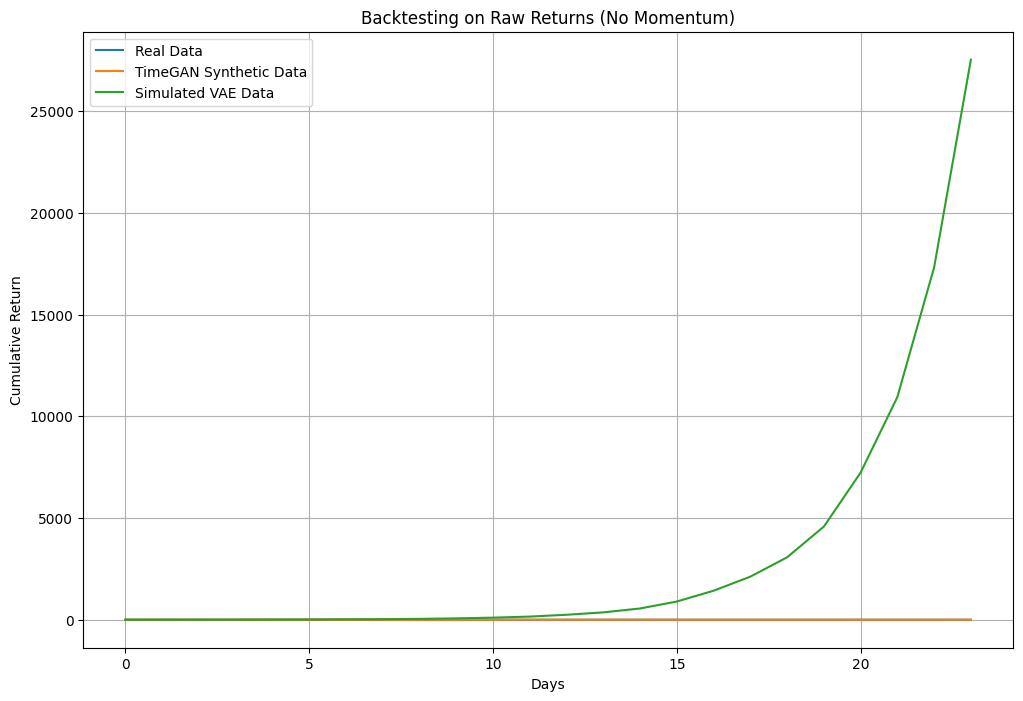

In [10]:
def momentum_strategy(returns):
    """If previous return > 0, stay invested, else move to cash (return 0)."""
    momentum_returns = []
    for i in range(1, len(returns)):
        if returns[i-1] > 0:
            momentum_returns.append(returns[i])
        else:
            momentum_returns.append(0)
    momentum_returns = np.array(momentum_returns)
    return momentum_returns

# Apply strategy on one asset (take the first asset)
real_asset_returns = real_returns[:, 0]
timegan_asset_returns = timegan_returns[:, 0]
vae_asset_returns = vae_returns[:, 0]

# Apply momentum strategy
real_momentum = momentum_strategy(real_asset_returns)
timegan_momentum = momentum_strategy(timegan_asset_returns)
vae_momentum = momentum_strategy(vae_asset_returns)

# Compute cumulative returns
def cumulative_returns(returns):
    return np.cumprod(1 + returns) - 1


real_cum = cumulative_returns(real_asset_returns)
timegan_cum = cumulative_returns(timegan_asset_returns)
vae_cum = cumulative_returns(vae_asset_returns)

# Plot cumulative returns
plt.figure(figsize=(12,8))
plt.plot(real_cum, label='Real Data')
plt.plot(timegan_cum, label='TimeGAN Synthetic Data')
plt.plot(vae_cum, label='Simulated VAE Data')
plt.title('Backtesting on Raw Returns (No Momentum)')
plt.xlabel('Days')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

## On 6 months 

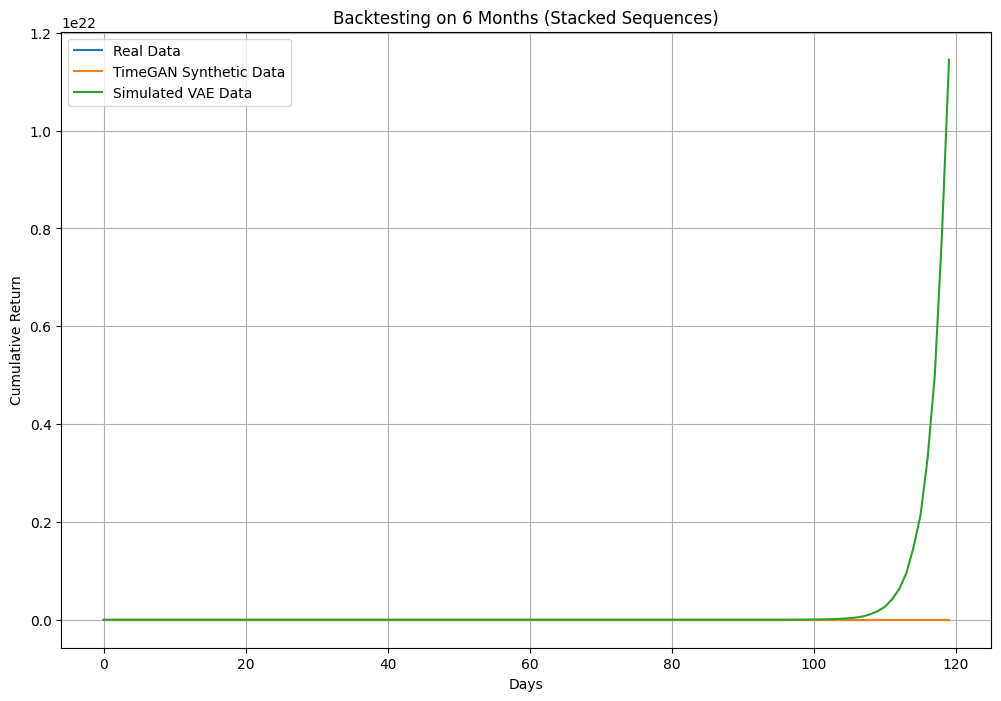

In [12]:
n_sequences_to_stack = 5  # 5 x 24 days = 120 trading days

# Stack real data
real_long = real_data_seq[:n_sequences_to_stack].flatten()
# Stack TimeGAN data
timegan_long = synthetic_timegan_seq[:n_sequences_to_stack].flatten()
# Stack VAE data
vae_long = synthetic_vae_seq[:n_sequences_to_stack].flatten()

# Cumulative returns
real_cum = cumulative_returns(real_long)
timegan_cum = cumulative_returns(timegan_long)
vae_cum = cumulative_returns(vae_long)

# Plot
plt.figure(figsize=(12,8))
plt.plot(real_cum, label='Real Data')
plt.plot(timegan_cum, label='TimeGAN Synthetic Data')
plt.plot(vae_cum, label='Simulated VAE Data')
plt.title('Backtesting on 6 Months (Stacked Sequences)')
plt.xlabel('Days')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import numpy as np
import pandas as pd

n_days = 252

# Pick first 252 days
synthetic_full_timegan = synthetic_timegan[:n_days]

# Save TimeGAN synthetic data
pd.DataFrame(synthetic_full_timegan, columns=['Synthetic_Close']).to_csv('../data/synthetic/timegan_synthetic_full.csv', index=False)

# --- OPTIONAL: Generate and save full synthetic VAE ---
synthetic_full_vae = np.random.normal(
    loc=np.mean(log_returns_array),
    scale=np.std(log_returns_array),
    size=(n_days, 1)
)

pd.DataFrame(synthetic_full_vae, columns=['Synthetic_Close']).to_csv('../data/synthetic/vae_synthetic_full.csv', index=False)

print("Synthetic datasets saved successfully into /data/synthetic/")


Synthetic datasets saved successfully into /data/synthetic/
